# PyTorchでシンプルなSiamese Networkをつくる

ここのところシャムネットワーク（以下「Siamese Network」）がらみの解説記事が続きましたが、やはり実際にプログラムを動かしていろいろ試してみたいところです。ネットで探してもSiamese Networkの実装記事は意外に少ないので、「いじり倒し」用にシンプルなモデルを動かしてみました。

自分にはあまり馴染みはないのですが、論文等でよく用いられるPyTorchを練習がてら使ってみます。MNISTデータセットによる簡易な手書き文字（数字）判定を課題とし、精度の向上よりも学習から評価までをできるだけシンプルにプログラミングすることを目標とします。

## １．GPUの設定

動作環境がCPUであるかGPUであるかを判定します。Colab環境では「cuda:0」と表示されればGPU使用可能環境となっています。

In [ ]:
import torch

# GPU設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda:0


## ２．MNISTデータセットの取得

MNISTデータセットはscikit-learnライブラリから取得することもできますが、PyTorchライブラリではtorchvisionパッケージからの取得が一般的なようです。
Datasetはindex値を指定すると個別に取り出すことができます。以下のプログラムでは：

* train_dataset_original[index][0] → 画像データ
* train_dataset_original[index][1] → ラベルデータ

となります。

In [ ]:
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

# 前処理（transforms）の定義
transform = transforms.Compose([
    transforms.ToTensor()                     # torch.tensorへ変換
])

# 学習用MNISTデータセットの取得
train_dataset_original = datasets.MNIST(
    './data',                                 # データファイルの保存ディレクトリ
    train = True,                             # 学習用データを取得
    download = True,                          # 保存ディレクトリにデータが無い場合はダウンロード
    transform = transform                     # 前処理（torch.tensorへの変換）を指定
)
print(f"Train Dataset Size: {len(train_dataset_original)}")

# テスト用MNISTデータセットの取得
test_dataset_original = datasets.MNIST(
    './data',                                 # データファイルの保存ディレクトリ
    train = False,                            # テスト用データを取得
    transform = transform                     # 前処理（torch.tensorへの変換）を指定
)
print(f"Test Dataset Size: {len(test_dataset_original)}")

# テスト用DataLoaderの作成（学習用は画像ペアが必要なので後ほど）
test_loader = DataLoader(
    test_dataset_original,                    # データセット
    batch_size=1,                             # バッチサイズは１なので１画像毎にモデルへ入力
    shuffle=True                              # データセットからランダムに取り出す
)


Train Dataset Size: 60000
Test Dataset Size: 10000


## ３．Siamese Network用データセットの作成

Siamese Networkの学習では入力画のペアを用意しなければならないため、オリジナルのMNISTデータセットを直接使うことはできません。いくつか方法はあるのですが、ここではMNISTデータセットのWrapperクラスを作り、画像のペアを出力するデータセットを定義します。

データセットクラスは自作が可能です。Datasetクラスを継承して、\_\_init\_\_()、 \_\_len\_\_()、 \_\_getitem\_\_()の各関数を定義すればよいのです。以下のプログラムでは\_\_init\_\_()にて画像ペアのペアインデックス配列を作成し、\_\_getitem\_\_()の引数にて指定されたインデックスに対応するペアインデックスを配列から取り出します。あとはペアインデックスの情報を基にオリジナルのMNISTデータセットから画像データのペアを取り出します（下図参照）：

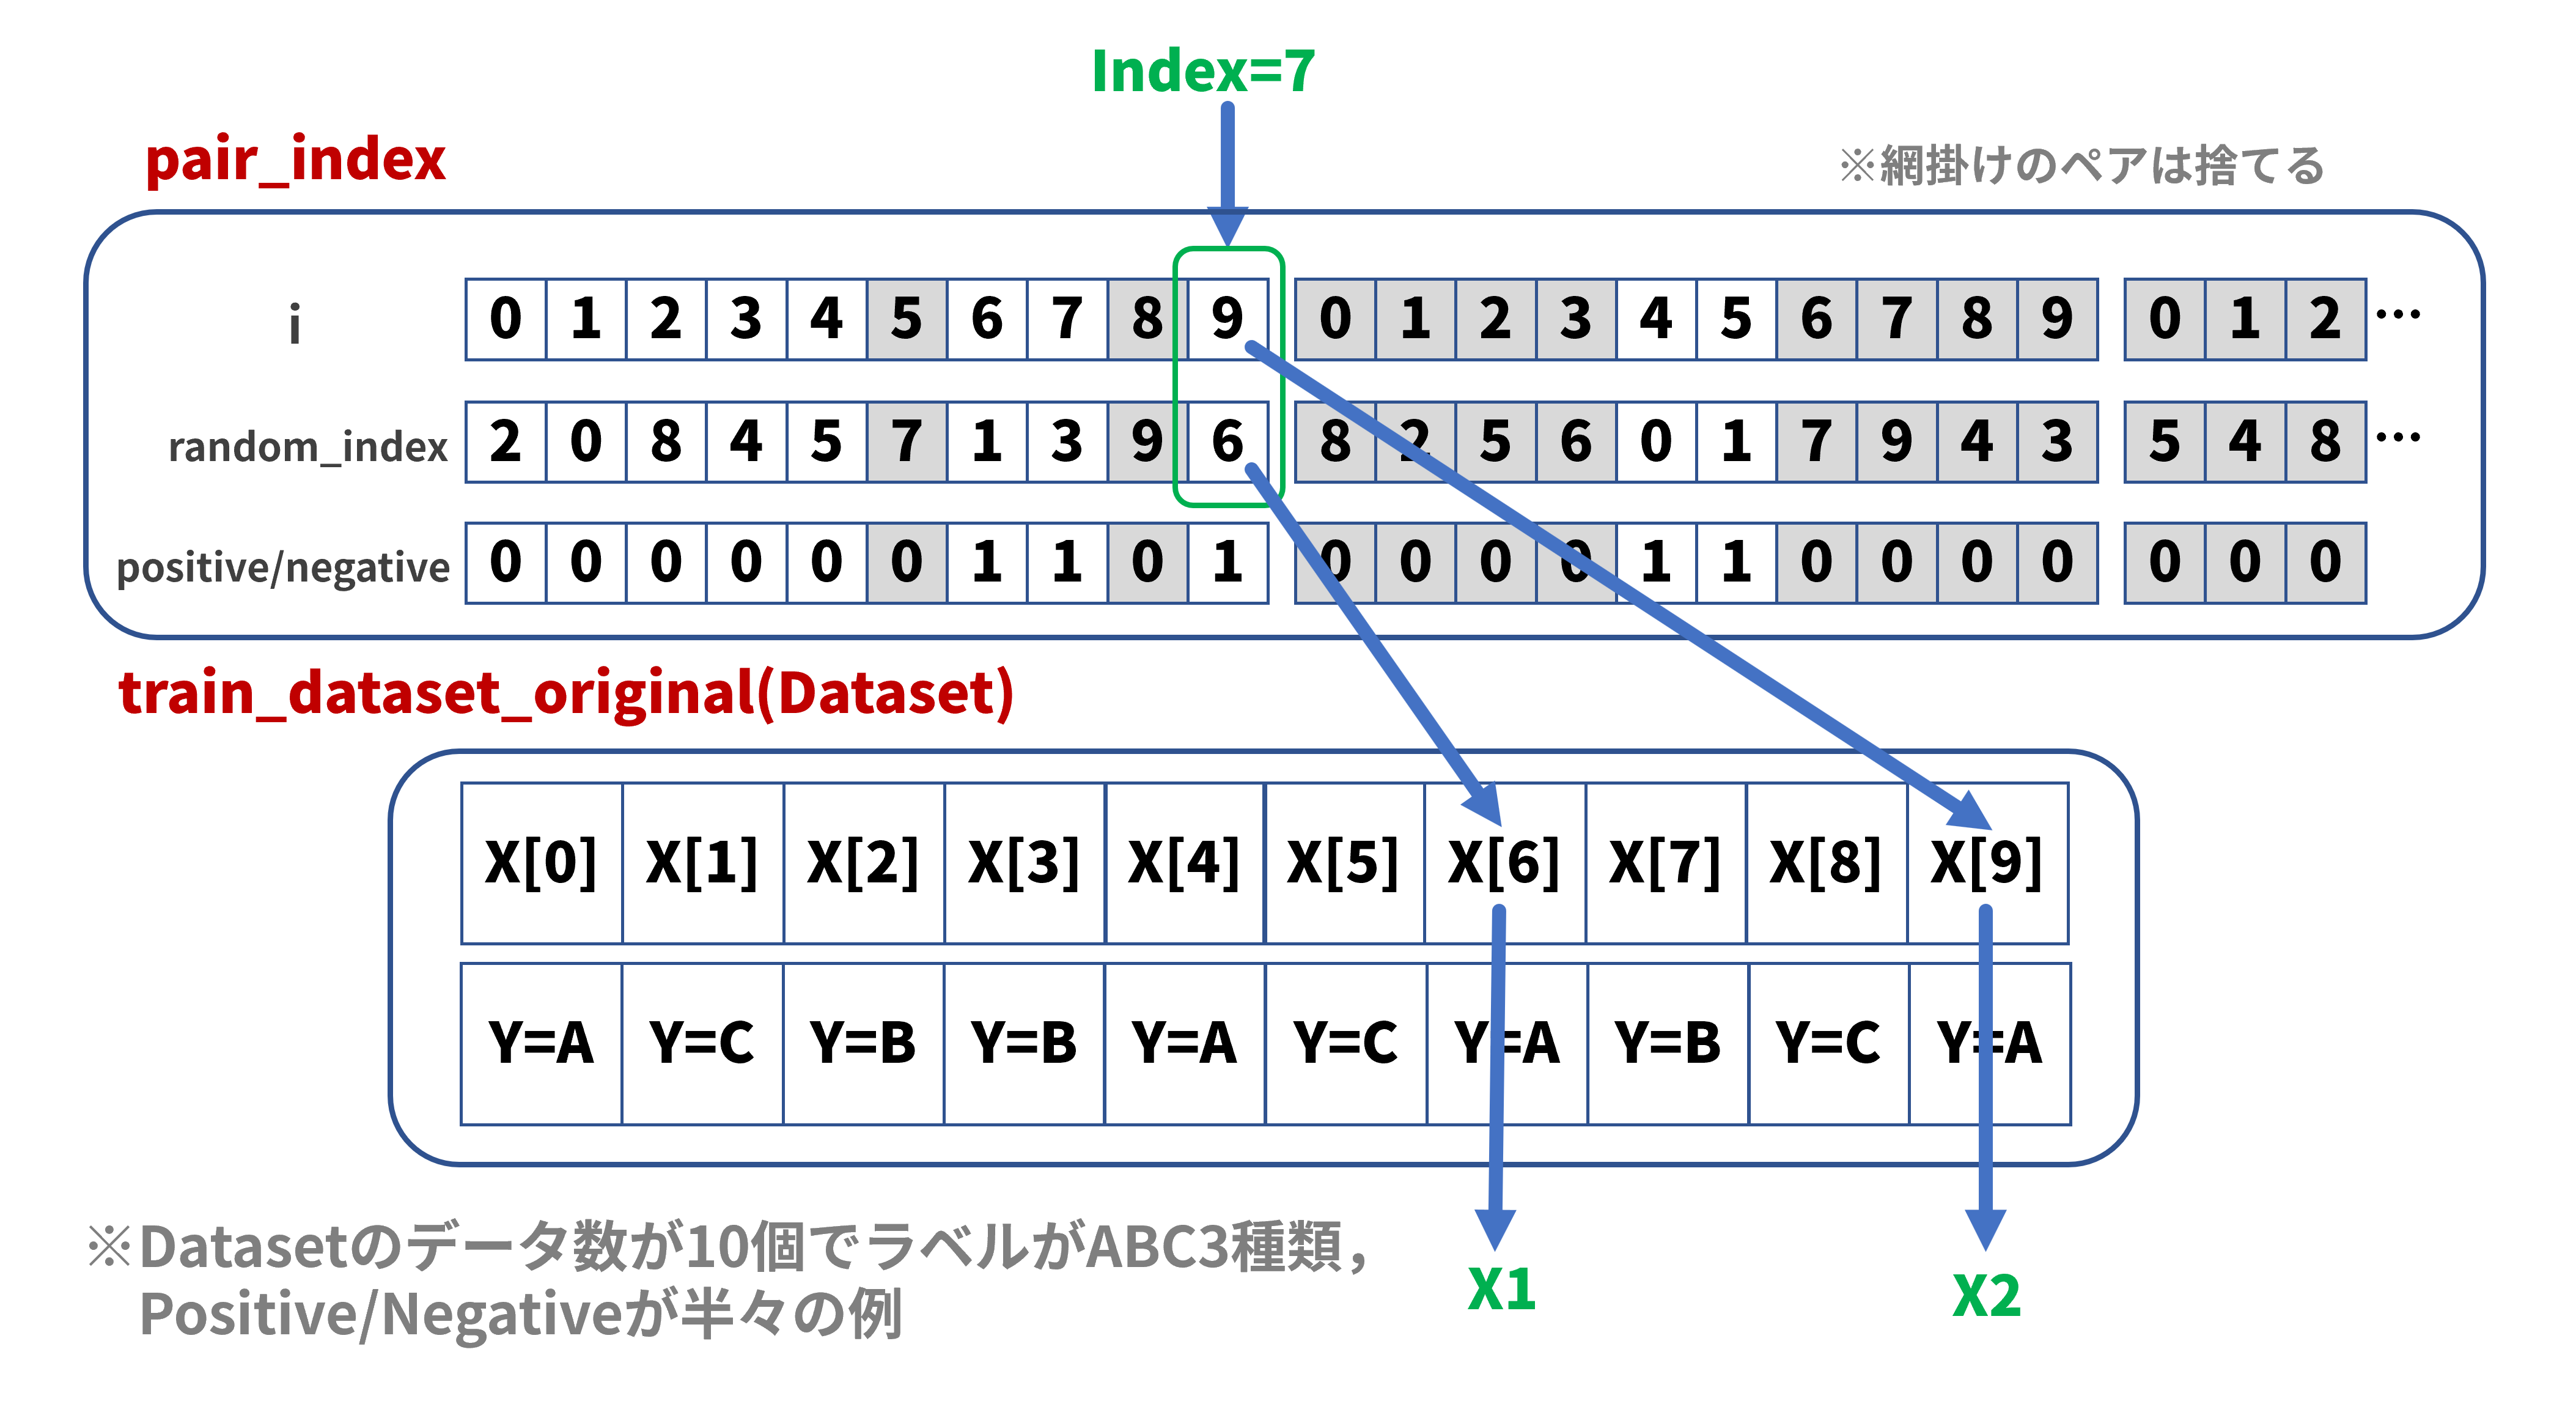

この方式ではデータの重複も発生しますが、データ数が多いので気にしていません。

データサイズについては元のMNISTデータセットと同じとしていますが、ペアの組み合わせ数は遥かに多いのでもっと増やすことはできます。また、Positiveデータ（ラベルが一致するペア）とNegativeデータ（ラベルが異なるペア）の割合が等しくなっていますが、Negativeデータの方が遥かに多いので、その比率を変えることも可能です。

torch.Size([1, 28, 28])
y[0]=1
y[1]=0
y[2]=1
y[3]=1


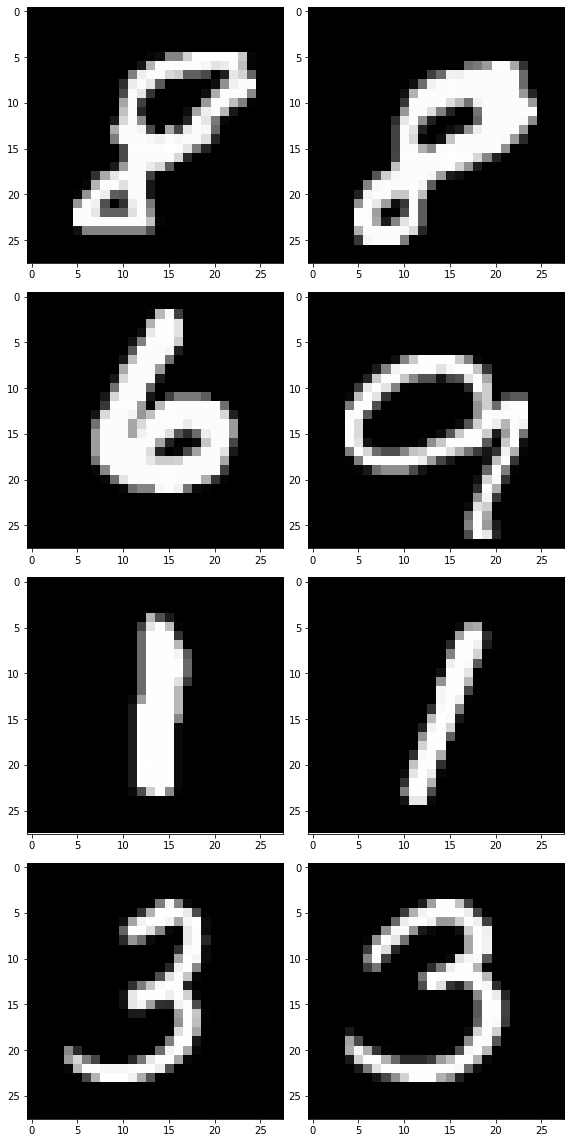

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Siamese Network用MNISTデータセットクラス
class SiameseMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset                                        # オリジナルのMNISTデータセット
        self.length = len(self.dataset)                               # 入力されたデータセットサイズと同じとする
        self.pair_index = []                                          # Siamse Network用画像ペアインデックス配列

        labels = [label for _, label in self.dataset]                 # 入力されたデータセットからラベル情報のみ抽出
        positive_count = 0                                            # Positiveペアのカウント
        negative_count = 0                                            # Negativeペアのカウント
        random_index = np.arange(self.length)

        while positive_count + negative_count < self.length:
          np.random.shuffle(random_index)                             # インデックス配列をランダムに並び替え
          for i in np.arange(self.length):
            if labels[i] == labels[random_index[i]]:                  # 画像ペアのラベルが等しい場合（＝Positive）
              if positive_count < self.length / 2:
                self.pair_index.append([i, random_index[i], 1])       # 要素の構成：[<画像1のインデックス>, <画像2のインデックス>, <Positive/Negativeフラグ>]
                positive_count += 1
              else:
                continue
            else:                                                     # 画像ペアのラベルが異なる場合（＝Negative）
              if negative_count < self.length / 2:
                self.pair_index.append([i, random_index[i], 0])       # 要素の構成：[<画像1のインデックス>, <画像2のインデックス>, <Positive/Negativeフラグ>]
                negative_count += 1
              else:
                continue
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        return self.dataset[self.pair_index[index][0]][0], self.dataset[self.pair_index[index][1]][0], torch.tensor(self.pair_index[index][2])

# Siamese Network学習用Dataset，DataLoaderの作成
batch_size = 64
train_dataset = SiameseMNIST(train_dataset_original)
train_loader = DataLoader(
    train_dataset,                                                    # データセット
    batch_size=batch_size,                                            # バッチサイズ
    shuffle=True                                                      # データセットからランダムに取り出す
)

# ペア画像の確認（画像表示）
X1, X2, y = iter(train_loader).next()                                 # １バッチ分だけデータを取り出す
print(X1[0].shape)
fig = plt.figure(tight_layout=True, figsize=(8, 16))
rows = 4                                                              # 表示行数，バッチサイズよりも小さな値で 
for i in range(rows):
    print(f"y[{i}]={y[i]}")
    ax = fig.add_subplot(rows, 2, i*2+1)
    ax.imshow(X1[i][0].numpy(), cmap='gray')                          # X1[i].shape = (1, 28, 28)，X1[i][0].shape = (28, 28)
    ax = fig.add_subplot(rows, 2, i*2+2)
    ax.imshow(X2[i][0].numpy(), cmap='gray')                          # X2[i].shape = (1, 28, 28)，X2[i][0].shape = (28, 28)


## ４．モデルの定義

課題がMNISTなので、単純なモデルでもそこそこうまくいくような気がします。また、後ほどパラメータの変化などを観察するにしても単純なモデルが望ましいため、全結合(Full Connected)３層モデルとしました。入力はバッチサイズ分の個数の画像ペア。出力は32次元ベクトル×２です。

Siamese Networkの説明図などを見ると２つのエンコーダが並んでいるような絵をよく見ますが、多くの実装例を見ると１つのエンコーダを用意して、同じエンコーダにデータを２回通すという構成がほとんどのようです。このモデルもその構成に倣いました。それがバックプロパゲーション時の自動微分にどのような影響を与えるのか気になるところですが、それは今後のネタとしたいと思います。


In [ ]:
import torch.nn as nn

# Siamse Networkモデルクラス
class SiameseMnistModel(nn.Module):
    
    def __init__(self):
        super(SiameseMnistModel, self).__init__()
        self.flatten = nn.Flatten()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )
    
    def forward_once(self, x):
        x = self.flatten(x)
        z = self.encoder(x)
        return z
  
    def forward(self, x1, x2):
        z1 = self.forward_once(x1)
        z2 = self.forward_once(x2)
        return z1, z2

## ５．損失関数の定義

損失関数は[以前の記事](https://qiita.com/saliton/items/2f7b1bfb451df75a286f)で紹介した「Contrastive Loss」を用います。式は以下の通りです：

$$
\mathcal{L}_{contrastive}=\frac{1}{2}YD^2+\frac{1}{2}(1-Y)max(margin-D,0)^2\\
D=||f(x_1)-f(x_2)||_2\\
Y= 
    \begin{cases}
        {0 \ (if\ x_2\ is\ negative\ sample)}\\
        {1 \ (if\ x_2\ is\ positive \ sample)}
    \end{cases}
$$

上式では$f(x_1)$、$f(x_2)$はモデル出力$z_1$、$z_2$を意味します。距離$D$は出力ベクトル$z_1$、$z_2$のユークリッド距離です。「Contrastive Loss」を用いて、サンプルペアが同じクラスに属する（Positive）ならば特徴ベクトルを近づける、サンプルペアが異なるクラスに属する（Negative）ならば特徴ベクトルを遠ざけるように学習が進むので、ラベル情報$Y$の値「0/1」で距離の計算式を切り分けています。

Negativeペアの距離計算項で「margin」を指定する必要がありますが、最初にmargin=1.0と仮設定してモデルを学習し始め、学習途中（後半）におけるモデルの出力ベクトル間の距離を測定しました。距離の統計情報は、平均：0.813、最大：1.663、最小：0.023、中央値：0.492だったのでmargin=1.0は妥当な値と考えられ、そのままデフォルト値として使いました。

In [ ]:
# 損失関数
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, z1, z2, y):
        difference = z1 - z2
        distance_squared = torch.sum(torch.pow(difference, 2), 1)
        distance = torch.sqrt(distance_squared)       #平均：0.813，最大：1.663，最小：0.023，中央値：0.492
        negative_distance = self.margin - distance
        negative_distance = torch.clamp(negative_distance, min=0.0)
        loss = (y * distance_squared + (1 - y) * torch.pow(negative_distance, 2)) / 2.0
        loss = torch.sum(loss) / z1.size()[0]
        return loss

## ６．学習の準備

モデルインスタンス化、最適化関数の定義（指定）、損失関数のインスタンス化を実施します。このあたりはPyTorchにおける定石のようです。

In [ ]:
import torch.optim as optim
from torchsummary import summary

# モデルのインスタンス化
model = SiameseMnistModel().to(device)                # GPUを使用するには「.to(device)」が必要
print(model.parameters)
summary(model, input_size=[(1, 28*28), (1, 28*28)])   # 入力が２つあるので（ペア画像だから）input_sizeはリストで複数指定する

# 最適化関数の定義
optimizer = optim.SGD(model.parameters(), lr=0.05)    # パラメータ探索アルゴリズム=確率的勾配降下法(SGD), 学習率lr=0.05

# 損失関数のインスタンス化
criterion = ContrastiveLoss()                         # 引数として「margin=○○」が指定できる。デフォルト値は「margin=1.0」

<bound method Module.parameters of SiameseMnistModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
  )
)>
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 32]           4,128
           Flatten-7                  [-1, 784]               0
            Linear-8                  [-1, 128]         100,480
          

## ７．学習の実行

こちらもPyTorchにおける定石です。冒頭にてmodel.train()で学習モードに設定します。

入力データによってモデルの出力ベクトルの要素がすべて「nan（非数）」になることがあり、その結果損失関数値もnanになってしまうことがあります。通常はnanが発生した時点で学習ループがストップするのですが、このプログラムではnanの計算を無かったこととして、１回前のモデルの状態に戻して次の計算を継続します。

epoch=0
nan/normal: 4/934
epoch=1
nan/normal: 4/934
epoch=2
nan/normal: 4/934
epoch=3
nan/normal: 4/934
epoch=4
nan/normal: 4/934
epoch=5
nan/normal: 4/934
epoch=6
nan/normal: 4/934
epoch=7
nan/normal: 4/934
epoch=8
nan/normal: 4/934
epoch=9
nan/normal: 4/934


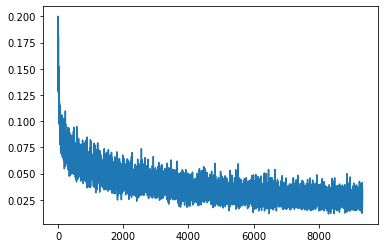

In [ ]:
import copy
import matplotlib.pyplot as plt

# モデル学習
repeat = 10                                                       # 学習回数
losses = []                                                       # 表示用損失値配列

model.train()                                                     # 学習モード
for epoch in range(repeat): 
  print(f"epoch={epoch}")
  nan_count = 0
  normal_count = 0

  for X1, X2, y in train_loader:                                  # 学習用DataLoader
    # モデルによる特徴ベクトル算出
    output1, output2 = model(X1.to(device), X2.to(device))

    # 損失関数の計算
    loss = criterion(output1, output2, y.to(device))

    # nan対策（lossにnanが含まれていれば１回前のモデルに戻す）
    if torch.isnan(loss):
      model = prev_model
      optimizer = optim.SGD(model.parameters(), lr=0.05)
      optimizer.load_state_dict(prev_optimizer.state_dict())
      nan_count += 1
      continue
    else:
      prev_model = copy.deepcopy(model)
      prev_optimizer = copy.deepcopy(optimizer)
      normal_count += 1

    # 表示用lossデータの記録
    losses.append(loss.item())

    # 勾配を初期化
    optimizer.zero_grad()
    
    # 損失関数の値から勾配を求め誤差逆伝播による学習実行
    loss.backward()
    
    # 学習結果に基づきパラメータを更新
    optimizer.step()

  print(f"nan/normal: {nan_count}/{normal_count}")
plt.plot(losses)                                                  # loss値の推移を表示


## ８．モデル出力ベクトルの取得

モデル学習の結果、同じ数字に属する画像の出力ベクトルは近くに、異なる数字に属する画像の出力ベクトルは遠くに配置されるはずです。これを確認するために、まず、テストデータを用いて出力ベクトルを集めます。

冒頭にてmodel.eval()で評価モードに設定し、変数の勾配も再計算されないようにtorch.no_grad()を記述します。テスト用DataLoaderはバッチサイズを1に指定しているのでループ毎に1つの出力ベクトルを計算します。後で使いまわすため、出力ベクトルの配列（z_test）とラベルの配列（y_test）を取得します。

In [ ]:
# モデル評価
model.eval()                                                      # 評価モード
with torch.no_grad():
    z_test = []
    y_test = []
    for X, y in test_loader:                                      # テスト用DataLoader
        z_test.append(model.forward_once(X.to(device)))           # テストデータをモデルに通して出力ベクトルを得る
        y_test.append(y)
    z_test = torch.cat(z_test, dim=0)                             # 多次元torch.tensor要素のリストをtorch.tensor化
    y_test = torch.tensor(y_test)                                 # スカラ要素(int)リストをtorch.tensor化


## ９．モデル出力ベクトルの分布を可視化

32次元ベクトルを2次元に次元削減して、出力ベクトルの分布を見てみます。次元削減アルゴリズムとして定番のt-SNEを用います。ちょっと見た感じではラベル単位で完全に分離はしていないものの、ラベル単位で固まっている感じには見えます。モデル定義で出力ベクトルの次元を増やしたり減らしてりしても分離度にはあまり変化はありませんでしたが、全結合のみの単純なモデルでもそこそこの結果は出せそうです。


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


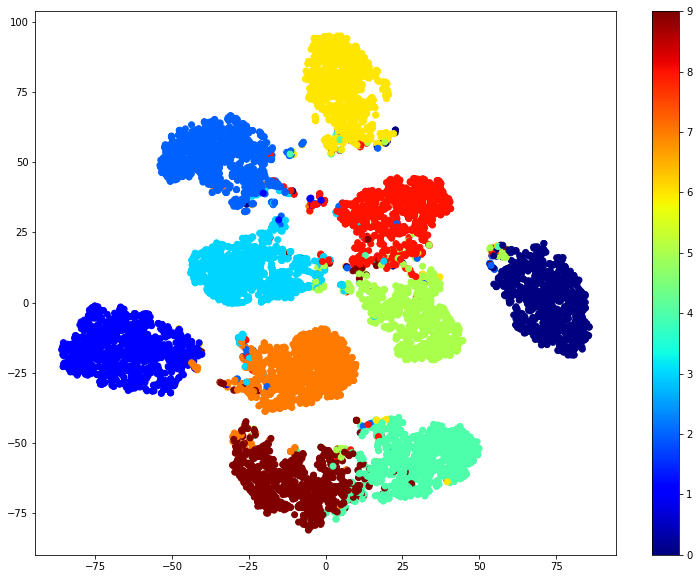

In [ ]:
from sklearn.manifold import TSNE

def plot_tsne(x, y, colormap=plt.cm.Paired):
    plt.figure(figsize=(13, 10))
    plt.clf()
    tsne = TSNE()
    x_embedded = tsne.fit_transform(x)
    plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=y, cmap='jet')
    plt.colorbar()
    plt.show()

# t-SNEによるベクトル分布表示
z_test_np = z_test.to('cpu').detach().numpy().copy()                    # t-SNEはdeviceとしてCPUのみに対応（GPUはダメ）
y_test_np = y_test.to('cpu').detach().numpy().copy()
plot_tsne(z_test_np, y_test_np)


## １０．クラスタリングによる評価

実際に上記出力ベクトル群のクラスタリングを実行します。クラスタリングの手法いくつかありますが、ここでは[以前の記事](https://qiita.com/saliton/items/40edf61af614d6b2b48d)で紹介した「k-means」法を使いました。クラスタリングのプログラムはわずか２行です。０～９の画像を入力データとしているのでクラスタ数は10です。

クラスタのラベル付けはk-meansが適当に０～９の数字を割り当てています。したがって、例えばクラスタラベルが９であっても、そのクラスタの画像が「９」を示すとは限りません。そこで、クラスタラベル毎にクラスタ画像に対応するテスト画像ラベルの最も多いものを新たなクラスタラベルとして書き換えます。これで、クラスタラベルが９ならばクラスタ画像も「９」を示し、クラスタラベルはテスト画像ラベルとの比較が可能になります。

最後に、各テスト画像毎にクラスタラベルとテスト画像ラベルが一致している数を調べて正解率（accuracy）を計算します。

In [ ]:
from sklearn.cluster import KMeans

# k-meansによるクラスタリング
kmeans = KMeans(n_clusters=10)                                             # クラスタ数は10で指定します
kmeans.fit(z_test_np)

# ラベルの付け替え
counts = {}
for cluster_label, test_label in zip(kmeans.labels_, y_test_np):           # cluster_label：クラスタラベル，test_label：テスト画像ラベル
  if cluster_label not in counts.keys():
    counts[cluster_label] = [0] * 10                                       # 「<cluster_label>:[0,0,0,0,0,0,0,0,0,0]」をcountsに追加（初期化）
  counts[cluster_label][test_label] += 1
print(counts)
mapping = {}
for cluster_label in range(10):
  mapping[cluster_label] = counts[cluster_label].index(max(counts[cluster_label]))

# 正解率の計算
mapped_cluster_label = np.array([mapping[cluster_label] for cluster_label in kmeans.labels_])
accuracy = sum(mapped_cluster_label == y_test_np) / len(y_test_np)* 100
print(accuracy)

{9: [5, 8, 13, 21, 4, 39, 5, 2, 928, 21], 4: [2, 1, 1, 8, 0, 805, 7, 0, 11, 4], 5: [964, 0, 11, 0, 1, 9, 8, 1, 2, 4], 1: [0, 1, 0, 0, 38, 10, 0, 33, 8, 920], 6: [1, 5, 981, 12, 2, 1, 1, 15, 2, 0], 7: [0, 0, 2, 0, 924, 1, 7, 1, 2, 35], 0: [7, 1, 9, 0, 13, 5, 928, 0, 6, 1], 8: [1, 1, 10, 10, 0, 0, 0, 967, 5, 14], 2: [0, 1, 4, 959, 0, 22, 0, 1, 8, 5], 3: [0, 1117, 1, 0, 0, 0, 2, 8, 2, 5]}
94.93


## １１．まとめ

今回はPyTorchにてシンプルなSiamese Networkを作って動かしてみました。Siamese Network特有なのは以下の部分でした：

* 入力データ用に画像ペアを生成するための Wrapper Datasetクラス
* ２入力、２出力のモデル
* ２入力の損失関数
* 出力ベクトル評価のためのクラスタリング

一旦このような環境を作ってしまえば、あとはSimSiam等のいろいろなバリエーションにも応用できそうです。SimSiamでは勾配停止（Stop-Gradient）の理解が不可欠ですが、このような環境で実際に試してみれば理解も深まりそうです。次回以降のネタとして上げられればと思います。
